In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
seed = 123
rng = np.random.default_rng(seed)
import scipy.signal as sig

import IPython.display as ipd
import matplotlib.pyplot as plt

import colorednoise as cn

from hr.esm import EsmModel
from hr.process import Esprit, Ester, NoiseWhitening
from hr.util import _PINK_FILTRE_COEFFS
from util.util import to_db, snr

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simple noiseless 'harmonic' signal

In [5]:
sr = 44100
n_s = 100000
n_fft = 1024

# number of sinusoids
r = 8 
# Normalised damping ratios, multiply by sampling rate to get the 'deltas' in Amp.s-1
gammas = rng.uniform(0.001, 0.01, r) 
# Normalised frequencies
nus = rng.normal(0.1, 0.05, r)
amps = rng.uniform(0.1, 1, r)
phis = rng.uniform(0, 2*np.pi, r)

x_esm = EsmModel(gammas, nus, amps, phis)

x_sine = x_esm.synth(n_s)

n_est = 20
x_esm_est, _, _ = Esprit.estimate_esm(x_sine, n_est, r)

print(x_esm.nus * sr)
print(x_esm_est.nus * sr)
print(x_esm.gammas * sr)
print(x_esm_est.gammas * sr)

[1628.17130119 2924.36107428 3000.87247855 3543.90924573 4064.97190875
 4274.6982726  6015.52126515 7563.01445135]
[1628.17129898 2924.44772651 3000.85545965 3543.90909811 4064.97210541
 4274.69839267 6015.52126549 7563.01445131]
[387.86597726 360.44658626 387.50649783 253.28300315 154.38473372
 162.94690078 130.68090639 334.13544355]
[387.86598068 360.28854268 387.41812112 253.28447783 154.38470108
 162.9469883  130.68090558 334.13544242]


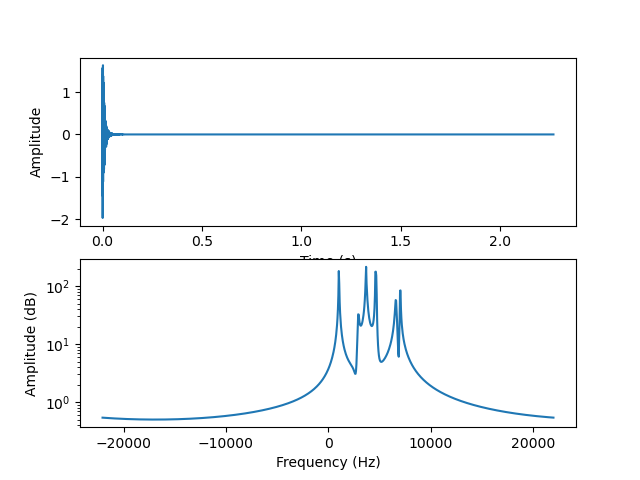

In [7]:
ts_plot = np.arange(n_s) / sr # times in seconds
fs_plot = np.fft.fftfreq(n_fft) * sr

_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
x_sine_ft = np.fft.fft(x_sine, n=n_fft)
plt.title("Time and frequency representation of the synthesised signal")
plt.subplot(2, 1, 1)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(ts_plot, np.real(x_sine))
plt.subplot(2, 1, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_plot), np.fft.fftshift(np.abs(x_sine_ft)))
plt.show()

In [6]:
ipd.Audio(np.real(x_sine), rate=sr)

### Adding noise

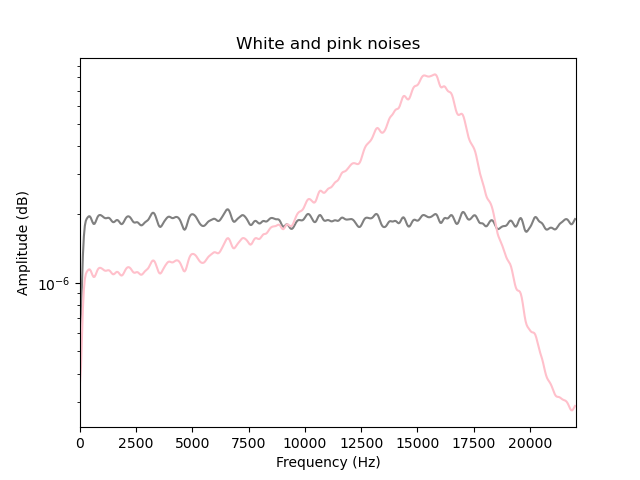

In [7]:
white_noise = rng.random(n_s)
pink_noise = sig.lfilter(_PINK_FILTRE_COEFFS["b"], _PINK_FILTRE_COEFFS["a"], white_noise)

fs_psd, white_noise_psd = sig.welch(white_noise, fs=sr, nfft=n_fft, return_onesided=False)
_, pink_noise_psd = sig.welch(pink_noise, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
plt.title("White and pink noises")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_psd), np.fft.fftshift(white_noise_psd), c='grey')
plt.semilogy(np.fft.fftshift(fs_psd), np.fft.fftshift(pink_noise_psd), c='pink')
plt.xlim(np.array([0, 0.5])*sr)
plt.show()

### Whitening the noise

In [17]:
noise_ratio = 0.001
noise = noise_ratio*pink_noise

x = x_sine + noise
print(np.mean(np.real(x_sine)), np.mean(noise))
x_snr =snr(np.real(x_sine), noise)
print(f'SNR={x_snr} dB')

2.770358507180402e-05 0.0003818879071629539
SNR=35.21543916999485 dB


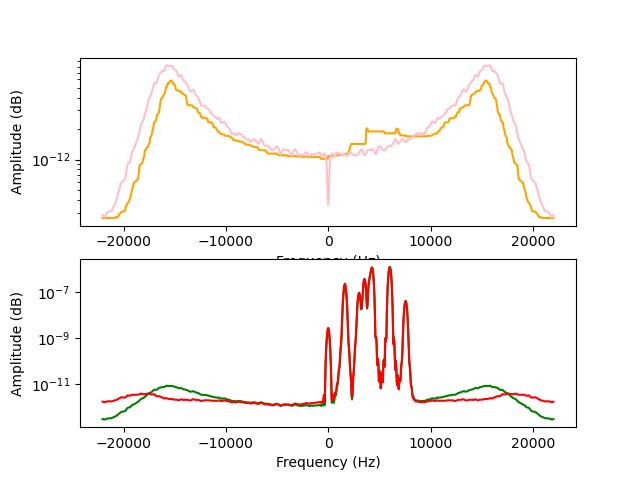

In [18]:
smoothing_factor = 8
quantile_ratio = 0.05
ar_ordre = 10

# fs_x_psd, x_psd = sig.welch(x, fs=1, nfft=n_fft)
fs_x_psd, x_psd = sig.welch(x, fs=sr, nfft=n_fft, return_onesided=False)
fs_noise_psd, noise_psd = sig.welch(noise, fs=sr, nfft=n_fft, return_onesided=False)

noise_psd_est = NoiseWhitening.estimate_noise_psd(x, fs=sr, n_fft=n_fft, quantile_ratio=quantile_ratio, smoothing_factor=smoothing_factor)
noise_filtre_coeffs_est = NoiseWhitening.estimate_noise_ar_coeffs(x, fs=sr, n_fft=n_fft, ar_ordre=ar_ordre, quantile_ratio=quantile_ratio, smoothing_factor=smoothing_factor)
# TODO: compare
# print(_PINK_FILTRE_COEFFS)
# print(noise_filtre_coeffs_est)
x_white = NoiseWhitening.whiten(x, fs=sr, n_fft=n_fft, ar_ordre=ar_ordre, quantile_ratio=quantile_ratio, smoothing_factor=smoothing_factor)
_, x_white_psd = sig.welch(x_white, fs=sr, nfft=n_fft, return_onesided=False)
_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
plt.title("PSD estimation of the noise and whitened signal")
plt.subplot(2, 1, 1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(noise_psd_est), c='orange')
plt.semilogy(np.fft.fftshift(fs_noise_psd), np.fft.fftshift(noise_psd), c='pink')
# plt.xlim(np.array([0, 0.5]) * sr)
plt.subplot(2, 1, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
# plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_psd), c='green')
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='r')
plt.show()

In [19]:
ipd.Audio(np.real(x), rate=sr)


### ESM model ordre estimation

#### Does seem to work correctly with the whitened signal!

The whitening process seems to hurt the estimation
of the ESM model ordre with ESTER.
We should use ESTER with the signal whose noise
has not been whitened.

#### Choice of $p_{max}$

According to the article, $p_{max}$ should be 
much lower than $n$.
So according to our expectation on $r$, we should choose
$n$ large enough.

Still unclear, but if $p_{max} > r$
the _a posteriori error bound_ from $E$ 
gives some indication somehow?

In the article:

For each eigenvalue ̂$\hat{z}$ of $\Phi(p)$, 
there is an eigenvalue $z_k$ of $\Phi(r)$ for which:

$$
|\hat{z} − z_k| \leq \kappa_2 ||E(p)||_2
$$ 


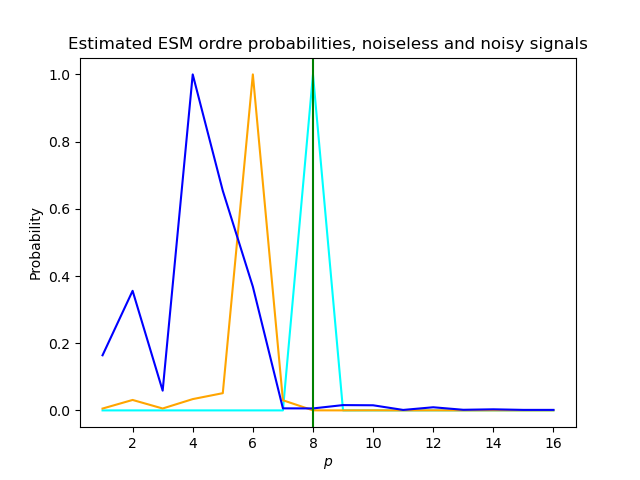

Ordre of the ESM model
Truth=8
Estimated: Noiseless=8, Noisy=6, Whitened=4


In [20]:
n_est = 32
p_max = 16 # for now
ps = np.arange(1,p_max+1)
j_sine = Ester.inverse_error_func(x_sine, n=n_est, p_max=p_max)
j_noise = Ester.inverse_error_func(x, n=n_est, p_max=p_max)
j_white = Ester.inverse_error_func(x_white, n=n_est, p_max=p_max)

plt.figure()
plt.title('Estimated ESM ordre probabilities, noiseless and noisy signals')
plt.xlabel('$p$')
plt.ylabel('Probability')
plt.plot(ps, j_sine/np.max(j_sine), c='cyan')
plt.plot(ps, j_noise/np.max(j_noise), c='orange')
plt.plot(ps, j_white/np.max(j_white), c='b')
plt.axvline(r, ymin=0, ymax=1, c='g')
plt.show()

r_est_sine = Ester.estimate_esm_ordre(x_sine, n_est, p_max)
r_est_noise = Ester.estimate_esm_ordre(x, n_est, p_max)
r_est_white = Ester.estimate_esm_ordre(x_white, n_est, p_max)
print('Ordre of the ESM model')
print(f'Truth={r}')
print(f'Estimated: Noiseless={r_est_sine}, Noisy={r_est_noise}, Whitened={r_est_white}')

### Test of the model with whitened signal


We use the ESM model ordre estimated on the 
whitened signal, and apply ESPRIT on
the whitened signal.

[1628.17130119 2924.36107428 3000.87247855 3543.90924573 4064.97190875
 4274.6982726  6015.52126515 7563.01445135]
[1663.85554152 3345.63039681 4200.58732321 6012.83837234]


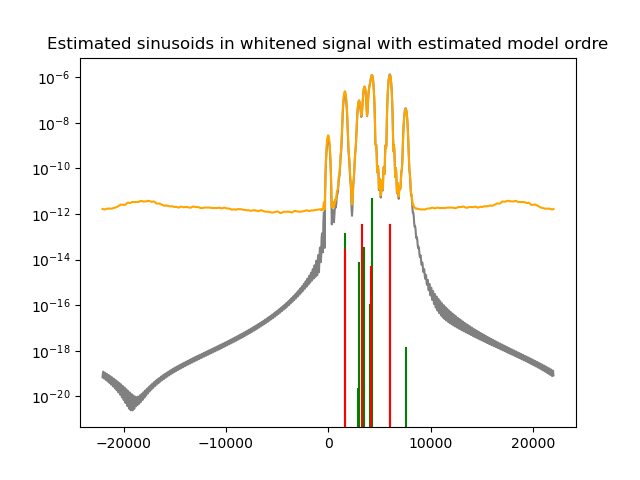

In [21]:
x_esm_est, _, _ = Esprit.estimate_esm(x_white, n_est, r_est_white)


print(x_esm.nus * sr)
print(x_esm_est.nus * sr)

plt.figure()
plt.title("Estimated sinusoids in whitened signal with estimated model ordre")
# plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_sine_psd), c='grey')
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='orange')
for j in range(len(x_esm.nus)):
    plt.axvline(x_esm.nus[j] * sr, 0, x_esm.amps[j], c='g')
    pass
for j in range(len(x_esm_est.nus)):
    plt.axvline(x_esm_est.nus[j] * sr, 0, x_esm_est.amps[j], c='r')
plt.show()


In [22]:
x_sine_est = x_esm_est.synth(n_s)
ipd.Audio(np.real(x_sine_est)/np.max(np.abs(x_sine_est)), rate=sr)

### Filter bank


#### Problem

__What transformation to apply to the estimated frequency in the band $\nu_{i,\text{band}}^k$ to apply to find the estimated frequency $\nu_i^k$?__

$$
\nu_i^k = \frac{\nu_{i,\text{band}}^k}{s} + \nu_c^k
$$

With $\nu_c^k = \frac{k}{N_{ft}}$ the centre frequency for band $k$, and $s$ the step in the STFT.

[0.29259079712877123, -0.2327945950895305, -0.4612141904965737, -0.34890044512821, 0.32392867488165544, -0.19237624095259784, -0.24128571021673262, -0.3387156386890051, -0.16669869825900083, 0.1847620560402579, -0.13365537734250252, -0.23441440055344293, 0.21615711085241957, -0.1018123702686354, 0.24753028596538934, 0.6126578125119679, -0.06774328774862035, -0.11303997247146369, 0.2793163610381242, 0.3100150432489256, 0.5907706124395745, -0.24683820362679254, -0.13769328765558708, 0.6211997801003462, 0.34160718955780134, -0.04094081054264975, 0.023472312849579208, 0.3724606817963614, 0.6534634934517245, -0.013836742553661685, -0.07672351023713625, 0.08471853612876742, 0.4033616767301366, 0.1370249176008843, 0.692488319020895, 0.4349907569318391, 0.5994693052486687, 0.7165976330506099, -0.017088605680205426, 0.5193393822081888, 0.14677868997748014, 0.46596520700472976, 0.33107591103875084, 0.02603787872830904, 0.2089973319053441, 0.5283189107062938, 0.7445354758819178, -0.27732139150370

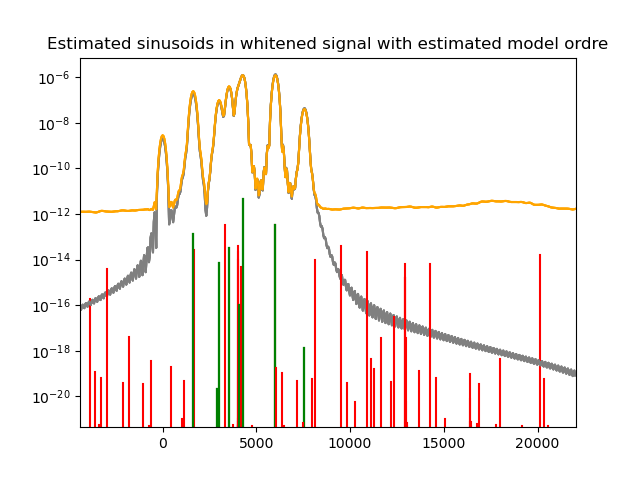

In [24]:
# number of bands
n_fb = 32
m_fb = n_fb//2
step_fb = 1

fs_fb, ts_fb, x_stft = sig.stft(x_sine, fs=sr,
    nperseg=m_fb, nfft=n_fb, return_onesided=False)
nus_centre = fs_fb / sr

rs_est = []
gammas_est = []
nus_est = []
amps_est = []
phis_est = []

n_est_fb = 8
p_max_fb = 4
for k in range(len(nus_centre)):
    x_band = x_stft[k]
    r_band = Ester.estimate_esm_ordre(x_band, n=n_est_fb, p_max=p_max_fb)
    rs_est.append(r_band)
    w_cap, _ = Esprit.subspace_weighting_mats(x_band, n_est, rs_est[k])
    phi_cap = Esprit.spectral_matrix(w_cap)
    zs = Esprit.estimate_poles(phi_cap)
    gammas_est_band, nus_est_band, amps_est_band, phis_est_band = Esprit.estimate_esm_params(x_band, zs)
    # TODO: Not right, fix this
    nus_est_band = nus_est_band/step_fb + nus_centre[k]
    nus_est += nus_est_band.tolist()
    gammas_est += gammas_est_band.tolist()
    amps_est += amps_est_band.tolist()
    phis_est += phis_est_band.tolist()

print(nus_est)
nus_est = np.array(nus_est)
print(np.amin(nus_est), np.amax(nus_est))
x_esm_est = EsmModel(gammas_est, nus_est, amps_est, phis_est)
#print(x_esm_est.nus * sr)
#print(x_esm_est.nus * sr)

plt.title("Estimated sinusoids in whitened signal with estimated model ordre")
plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_sine_psd), c='grey')
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='orange')
for j in range(len(x_esm.nus)):
    plt.axvline(x_esm.nus[j] * sr, 0, x_esm.amps[j], c='g')
for j in range(len(x_esm_est.nus)):
    plt.axvline(x_esm_est.nus[j] * sr, 0, x_esm_est.amps[j], c='r')
plt.show()

In [25]:
x_sine_est = x_esm_est.synth(n_s)
ipd.Audio(np.real(x_sine_est)/np.max(np.abs(x_sine_est)), rate=sr)